In [1]:
pip install opencv-python tqdm torchvision scikit-learn


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

os.listdir("/content/drive/MyDrive")


['Colab Notebooks',
 'Classroom',
 'photo.jpg',
 'AWS .jpg',
 'Marksheet_Btech.pdf',
 'Untitled document (5).gdoc',
 'Untitled document (4).gdoc',
 'Untitled document (3).gdoc',
 '1) Multi-task: Classification + Segmentation + Change-Detection (high novelty).gdoc',
 'Untitled document (2).gdoc',
 'Untitled document (1).gdoc',
 'ACM INTERNSHIP.jpeg',
 'AM HACKS.jpeg',
 'letter.pdf',
 'Untitled document.gdoc',
 'Classification of Maritime vessels from satellite imagery.gdoc',
 'Nitya_Choudhary_RESUME.pdf',
 'DSA.gsheet',
 'dataset.zip']

In [7]:
import zipfile
import os

ZIP_PATH = "/content/drive/MyDrive/dataset.zip"
EXTRACT_PATH = "/content/dataset.zip"

os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("Extraction done")


Extraction done


In [9]:
#verify extraction
os.listdir("/content/dataset.zip")


['ships-aerial-images']

In [13]:
os.listdir("/content/dataset.zip/ships-aerial-images")


['test', 'data.yaml', 'train', 'valid']

In [18]:
BASE_PATH= "/content/dataset.zip/ships-aerial-images"

In [19]:
import cv2
import os
from tqdm import tqdm

In [22]:
import cv2
import os
from tqdm import tqdm

def crop_ships(image_dir, label_dir, save_dir, min_area_ratio=0.001):
    os.makedirs(save_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(image_dir)):
        if not img_name.lower().endswith((".jpg", ".png")):
            continue

        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, img_name.rsplit(".", 1)[0] + ".txt")

        if not os.path.exists(label_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        h, w, _ = img.shape

        with open(label_path, "r") as f:
            lines = f.readlines()

        for i, line in enumerate(lines):
            parts = line.strip().split()

            # ✅ FIX: take only first 5 values
            if len(parts) < 5:
                continue

            cls, xc, yc, bw, bh = map(float, parts[:5])

            x1 = max(0, int((xc - bw / 2) * w))
            y1 = max(0, int((yc - bh / 2) * h))
            x2 = min(w, int((xc + bw / 2) * w))
            y2 = min(h, int((yc + bh / 2) * h))

            crop = img[y1:y2, x1:x2]

            # ❌ skip empty or tiny crops
            if crop.size == 0:
                continue

            area_ratio = (crop.shape[0] * crop.shape[1]) / (h * w)
            if area_ratio < min_area_ratio:
                continue

            save_name = f"{img_name[:-4]}_{i}.jpg"
            cv2.imwrite(os.path.join(save_dir, save_name), crop)


In [23]:
crop_ships(
    f"{BASE_PATH}/train/images",
    f"{BASE_PATH}/train/labels",
    "/content/crops/train/ship"
)

crop_ships(
    f"{BASE_PATH}/valid/images",
    f"{BASE_PATH}/valid/labels",
    "/content/crops/val/ship"
)

crop_ships(
    f"{BASE_PATH}/test/images",
    f"{BASE_PATH}/test/labels",
    "/content/crops/test/ship"
)


100%|██████████| 1573/1573 [00:04<00:00, 330.78it/s]


In [24]:
len(os.listdir("/content/crops/train/ship"))


11659

(np.float64(-0.5), np.float64(16.5), np.float64(33.5), np.float64(-0.5))

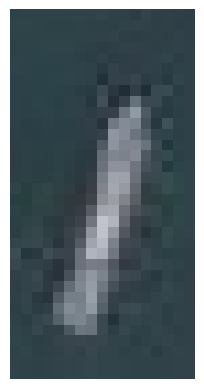

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/crops/train/ship/" + os.listdir("/content/crops/train/ship")[0])
plt.imshow(img)
plt.axis("off")


In [26]:
import cv2
import os
from tqdm import tqdm

IMG_SIZE = 224

def preprocess_image(img_path, rgb_dir, gray_dir, contrast_dir):
    img = cv2.imread(img_path)
    if img is None:
        return

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Grayscale
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

    # Contrast Enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast = clahe.apply(gray)

    fname = os.path.basename(img_path)

    cv2.imwrite(os.path.join(rgb_dir, fname), cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(gray_dir, fname), gray)
    cv2.imwrite(os.path.join(contrast_dir, fname), contrast)


In [27]:
splits = ["train", "val", "test"]

for split in splits:
    src_dir = f"/content/crops/{split}/ship"

    rgb_dir = f"/content/processed/rgb/{split}/ship"
    gray_dir = f"/content/processed/grayscale/{split}/ship"
    cont_dir = f"/content/processed/contrast/{split}/ship"

    os.makedirs(rgb_dir, exist_ok=True)
    os.makedirs(gray_dir, exist_ok=True)
    os.makedirs(cont_dir, exist_ok=True)

    for img_name in tqdm(os.listdir(src_dir)):
        preprocess_image(
            os.path.join(src_dir, img_name),
            rgb_dir,
            gray_dir,
            cont_dir
        )


100%|██████████| 1862/1862 [00:03<00:00, 537.61it/s]


In [28]:
os.listdir("/content/processed/rgb/train/ship")[:5]
os.listdir("/content/processed/grayscale/train/ship")[:5]
os.listdir("/content/processed/contrast/train/ship")[:5]


['m0098_png.rf.610d191b15b1c0c01328aceb02200187_3.jpg',
 'ship_000387_png.rf.1cd93fa619a5c73ed1cd105673f10803_0.jpg',
 'GE_50_jpg.rf.063358d6ffc64f3a6b8e9dd0647207c8_11.jpg',
 'y0011_png.rf.5b74486c311131c0c54fc21b9fcc5663_0.jpg',
 '20190326_054131_1021_3B_Visual_0_png.rf.7dc5bd2015a92964c32e6733269f21b5_0.jpg']

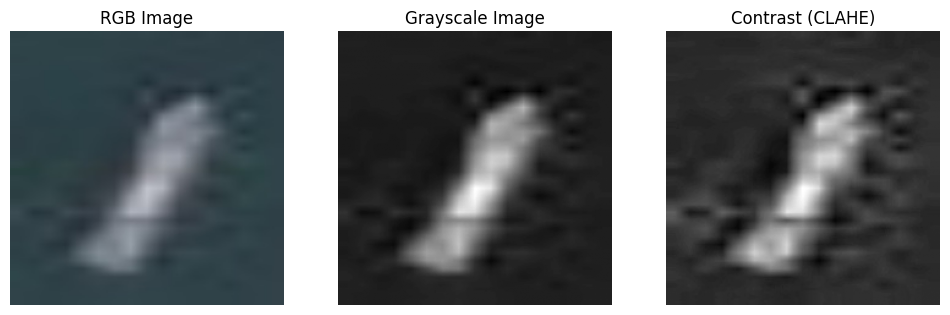

In [29]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
rgb_dir = "/content/processed/rgb/train/ship"
gray_dir = "/content/processed/grayscale/train/ship"
cont_dir = "/content/processed/contrast/train/ship"

# Pick same image name from RGB folder
img_name = os.listdir(rgb_dir)[0]

# Read images
rgb = cv2.imread(os.path.join(rgb_dir, img_name))
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

gray = cv2.imread(os.path.join(gray_dir, img_name), cv2.IMREAD_GRAYSCALE)
contrast = cv2.imread(os.path.join(cont_dir, img_name), cv2.IMREAD_GRAYSCALE)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("RGB Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(contrast, cmap="gray")
plt.title("Contrast (CLAHE)")
plt.axis("off")

plt.show()


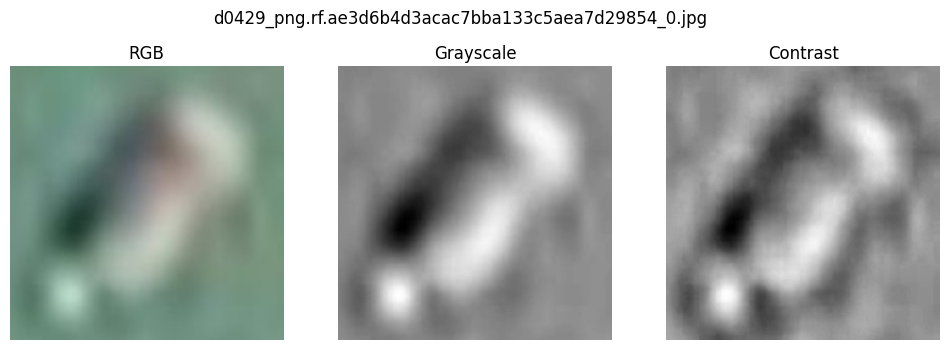

In [30]:
import random

files = os.listdir(rgb_dir)
img_name = random.choice(files)

rgb = cv2.cvtColor(cv2.imread(os.path.join(rgb_dir, img_name)), cv2.COLOR_BGR2RGB)
gray = cv2.imread(os.path.join(gray_dir, img_name), 0)
cont = cv2.imread(os.path.join(cont_dir, img_name), 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cont, cmap="gray"); plt.title("Contrast"); plt.axis("off")

plt.suptitle(img_name)
plt.show()


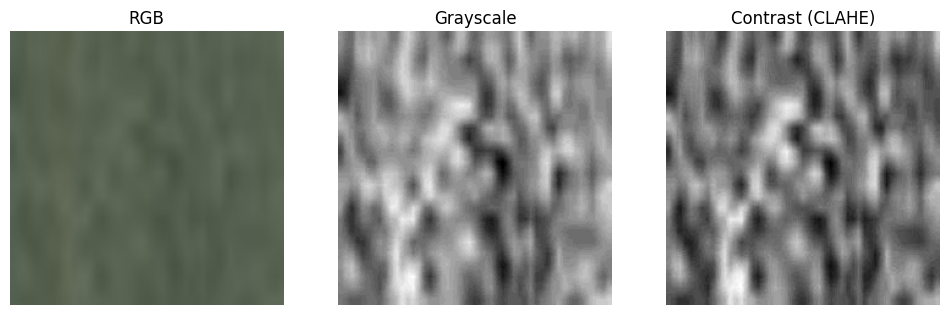

In [31]:
import os
import cv2
import matplotlib.pyplot as plt

rgb_dir = "/content/processed/rgb/train/ship"
gray_dir = "/content/processed/grayscale/train/ship"
cont_dir = "/content/processed/contrast/train/ship"

files = sorted(os.listdir(rgb_dir))

# 👇 change index to see other images
idx = 10   # try 0, 5, 10, 50, 100 ...

img_name = files[idx]

rgb = cv2.cvtColor(cv2.imread(os.path.join(rgb_dir, img_name)), cv2.COLOR_BGR2RGB)
gray = cv2.imread(os.path.join(gray_dir, img_name), 0)
cont = cv2.imread(os.path.join(cont_dir, img_name), 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(rgb); plt.title("RGB"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cont, cmap="gray"); plt.title("Contrast (CLAHE)"); plt.axis("off")

plt.show()


In [42]:
def blur_score(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0
    return cv2.Laplacian(img, cv2.CV_64F).var()


In [43]:
BLUR_THRESHOLD = 35
import os
from tqdm import tqdm

rgb_dir = "/content/processed/rgb/train/ship"
gray_dir = "/content/processed/grayscale/train/ship"
cont_dir = "/content/processed/contrast/train/ship"

removed = 0
kept = 0

for img_name in tqdm(os.listdir(rgb_dir)):
    rgb_path = os.path.join(rgb_dir, img_name)

    score = blur_score(rgb_path)

    if score < BLUR_THRESHOLD:
        # delete RGB
        os.remove(rgb_path)

        # delete grayscale
        gray_path = os.path.join(gray_dir, img_name)
        if os.path.exists(gray_path):
            os.remove(gray_path)

        # delete contrast
        cont_path = os.path.join(cont_dir, img_name)
        if os.path.exists(cont_path):
            os.remove(cont_path)

        removed += 1
    else:
        kept += 1

print("✅ Kept images:", kept)
print("🗑️ Removed blurred images:", removed)


100%|██████████| 11659/11659 [00:11<00:00, 998.63it/s] 

✅ Kept images: 3142
🗑️ Removed blurred images: 8517


In [44]:
rgb_files = set(os.listdir(rgb_dir))
gray_files = set(os.listdir(gray_dir))
cont_files = set(os.listdir(cont_dir))

print("RGB only:", len(rgb_files - gray_files))
print("Gray only:", len(gray_files - cont_files))
print("Contrast only:", len(cont_files - rgb_files))


RGB only: 0
Gray only: 0
Contrast only: 0


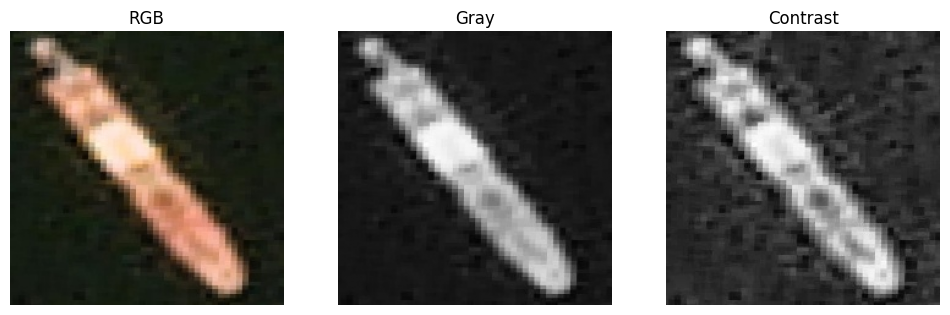

In [45]:
import random

img_name = random.choice(os.listdir(rgb_dir))

rgb = cv2.cvtColor(cv2.imread(os.path.join(rgb_dir, img_name)), cv2.COLOR_BGR2RGB)
gray = cv2.imread(os.path.join(gray_dir, img_name), 0)
cont = cv2.imread(os.path.join(cont_dir, img_name), 0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(rgb); plt.title("RGB"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(gray, cmap="gray"); plt.title("Gray"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(cont, cmap="gray"); plt.title("Contrast"); plt.axis("off")
plt.show()


In [46]:
  import os

splits = ["train", "val", "test"]
types = ["rgb", "grayscale", "contrast"]

total_images = 0

for split in splits:
    print(f"--- {split.upper()} ---")
    for t in types:
        dir_path = f"/content/processed/{t}/{split}/ship"
        if os.path.exists(dir_path):
            count = len([f for f in os.listdir(dir_path) if f.lower().endswith((".jpg", ".png"))])
            print(f"{t}: {count} images")
            total_images += count
        else:
            print(f"{t}: folder not found!")

print(f"\n✅ Total processed images across all types and splits: {total_images}")


--- TRAIN ---
rgb: 3142 images
grayscale: 3142 images
contrast: 3142 images
--- VAL ---
rgb: 2412 images
grayscale: 2412 images
contrast: 2412 images
--- TEST ---
rgb: 1862 images
grayscale: 1862 images
contrast: 1862 images

✅ Total processed images across all types and splits: 22248


In [47]:
import shutil

shutil.make_archive("/content/processed_dataset", 'zip', "/content/processed")


'/content/processed_dataset.zip'

In [48]:
from google.colab import files

files.download("/content/processed_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>